# Zrimec et. al 2021

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
import os
import time
import matplotlib.pyplot as plt
import random
%pip install scikit-bio
from sklearn.metrics import precision_recall_curve, auc
from sklearn import preprocessing
from skbio.diversity import alpha_diversity
from skbio.stats.distance import DistanceMatrix
from numpy import zeros
from skbio.stats.ordination import pcoa

import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 25.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 79.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.2-cp310-cp310-linux_x86_64.whl size=3971934 sha256=4ddd8b1364403692c32345abe89f9bcd7960726f1e9ef95346be8ffc73d19b57
  Stored in directory: /root/.cache/pip/wheels/f3/9c/ed/c2b94011fd3765a19330df93f81265e178098dd86c047c1566
  Created wheel for biom-format: filename=biom_format-2.1.16-cp310-cp310-linux_x86_64.whl size=12158973 sha256=265fc30191de0190d0dd830fb99ddfe0979c43121b2a9de7e17b05dd6d03dc85
  Stored in directory: /root/.cache/pip/wheels/8e/a9/f9/197fd5a0e5bbab5f2e03c89194f6c194bed7af5d7a8c8759f3
Successf

In [ ]:
# variables
from scipy import stats
e_cut = 1e-16
col = 'group_id'
corr_f = stats.spearmanr
palett = sns.color_palette("Paired",8)
label_hits = 'Num. plastic degrading enzymes'
label_plast = 'Num. degradable plastic types'
label_hits_n = 'Num. plastic\ndegrading enzymes'
label_plast_n = 'Num. degradable\nplastic types'

# plastics as additional
additives = ['PA','phthalate','DBP','TP']
depth_order=['SRF','DCM','MES']
ocean_order=['MS','RS','IO','SO','SAO','NAO','SPO','NPO']
ocean_long={'MS':'Mediterranean Sea','RS':'Red Sea',
            'IO':'Ionian Sea','SO':'Southern Ocean',
            'SAO':'South Atlantic Ocean','NAO':'North Atlantic Ocean',
            'SPO':'South Pacific Ocean','NPO':'North Pacific Ocean'}
df_ocean = pd.DataFrame(ocean_long.keys(),columns=['short'])
df_ocean['long'] = ocean_long.values()
df_ocean.set_index('short').loc[ocean_order].values

col_env = ['8_Latitude of event (Latitude)',
           '9_Longitude of event (Longitude)',
           '18_Depth, reference [m] (Depth ref)',
             '19_Conductivity [mS/cm] (Cond)',
             '20_Salinity (Sal)',
             '21_Temperature, water, potential [°C] (Tpot)',
             '22_Density, sigma-theta (0) [kg/m',
             '23_Oxygen [µmol/kg] (OXYGEN)',
             '25_Nitrate [µmol/l] ([NO3]-)',
             '27_Phosphate [µmol/l] ([PO4]3-)',
             '28_Nitrate and Nitrite [µmol/l] ([NO3]- + [NO2]-)',
             '29_Silicate [µmol/l] (Si(OH)4)']

dic_env = dict(zip(col_env, ['Nitrate_nitrite' if '28' in x else
                             x.split('_')[1].split(' ')[0].replace(',','')
                             for x in col_env]))
# add units
dic_env2 = {'8_Latitude of event (Latitude)': 'Latitude [°]',
 '9_Longitude of event (Longitude)': 'Longitude [°]',
 '18_Depth, reference [m] (Depth ref)': 'Depth [m]',
 '19_Conductivity [mS/cm] (Cond)': 'Conductivity [mS/cm]',
 '20_Salinity (Sal)': 'Salinity',
 '21_Temperature, water, potential [°C] (Tpot)': 'Temperature [°C]',
 '22_Density, sigma-theta (0) [kg/m': 'Density [kg/m]',
 '23_Oxygen [µmol/kg] (OXYGEN)': 'Oxygen [µmol/kg]',
 '25_Nitrate [µmol/l] ([NO3]-)': 'Nitrate [µmol/l]',
 '27_Phosphate [µmol/l] ([PO4]3-)': 'Phosphate [µmol/l]',
 '28_Nitrate and Nitrite [µmol/l] ([NO3]- + [NO2]-)': 'Nitrate_nitrite [µmol/l]',
 '29_Silicate [µmol/l] (Si(OH)4)': 'Silicate [µmol/l]'}

In [ ]:
# functions

def get_prc(df_hits,plastic,plot=False):
    precision, recall, thresholds = precision_recall_curve(df_hits.label.values,
                       df_hits.score.values,
                       pos_label='tara')
    prc_auc = auc(recall,precision)

    if plot==True:
        plt.plot(recall, precision, color='darkorange',
                 lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.title(plastic)
        plt.show()

    return precision, recall, thresholds, prc_auc

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = corr_f(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.3f}, p = {p:.1e}', xy=(.1, .9), xycoords=ax.transAxes)

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

# merge on closest value
# https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
import geopandas as gpd
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.iloc[idx].drop(columns = 'geometry').reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

def dframe_stack_list(ins,col,typ='float32'):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack().astype(typ)
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew, epsilon=False):
    """line fitting on log-log scale"""
    if epsilon==True:
        k, m = np.polyfit(np.log(x+1e-8), np.log(y+1e-8), 1)
    else:
        k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

#http://readiab.org/book/latest/3/1
def bray_curtis_distance(table, sample1_id, sample2_id):
    numerator = 0
    denominator = 0
    sample1_counts = table[sample1_id]
    sample2_counts = table[sample2_id]
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    if denominator == 0:
        denominator += 1e-8
    return numerator / denominator

def table_to_distances(table, pairwise_distance_fn):
    sample_ids = table.columns
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = pairwise_distance_fn(table, sample1_id, sample2_id)
    return DistanceMatrix(data, sample_ids)

def normalize(xx):
    mn = min(xx)
    mx = max(xx)
    return np.array([(x-mn)/(mx-mn) for x in xx])

# Load data

In [ ]:
# metadata
%pip install openpyxl
tara_metadata = (pd
                 .read_excel('Sunagawa_TableS1.xlsx',sheet_name='tableS1')
                 .rename(columns={'INSDC sample accession number(s)':'inscd_id',
                                  'INSDC run accession number(s)':'run',
                                  'Latitude [degrees North]':'latitude',
                                  'Longitude [degrees East]':'longitude'})
                )
tara_metadata['sample_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: ''.join(x.split('_')[:2]))
                             )
tara_metadata['depth_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: x.split('_')[2])
                             )
tara_metadata['depth_id2'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: x.split('_')[2])
                             )
tara_metadata['size_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: ''.join(x.split('_')[3:]))
                             )

# rename MIX as DCM
tara_metadata.loc[tara_metadata.depth_id=='MIX','depth_id'] = 'DCM'

print(tara_metadata.sample_id.unique().shape)
print(tara_metadata.shape)
tara_metadata.head()

# location grouping variables
marine_groups = ['Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]',
    'Marine provinces  (Longhurst 2007)',
    'Biogeographic biomes (Longhurst 2007)']

# define ocean, ocean province, biome
tara_metadata['ocean'] = tara_metadata[marine_groups[0]].apply(lambda x: x.split(')')[0][1:])
tara_metadata['ocean_province'] = tara_metadata[marine_groups[1]].apply(lambda x: x.split(')')[0][1:])
tara_metadata['biome'] = tara_metadata[marine_groups[2]]
tara_metadata['ocean_long'] = tara_metadata.ocean.map(ocean_long)
tara_metadata['group_id'] = tara_metadata.run

# prokaryote enriched fraction
print(tara_metadata[tara_metadata['size_id'].isin(['0.22-1.6','0.22-3'])].shape)
print(tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))&
              (tara_metadata.depth_id=='SRF')].shape)

# no pooling is required with this partitioning
(tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))&
              (tara_metadata.depth_id=='SRF')]
 .groupby('sample_id')['Size fraction upper threshold [micrometre]']
 .apply(lambda x: len(list(x)))
 .describe()
)
# replace id with the one we are using
to_replace = {'ERS492821|ERS492814':'ERS492814'}
tara_metadata = tara_metadata.replace({'inscd_id':to_replace})

tara_sample_map = pd.read_csv('tara-assembly-sample-mapping.txt'
                              ,sep='\t',names=['sample_id','inscd_id','samea_id'])

tara_sample_map['sample_id_short'] = (tara_sample_map
                                      .sample_id
                                      .apply(lambda x: x[:6])
                                     )
tara_sample_map

# load more env data
cols = (pd.read_csv('tara_env_column_names.tab',sep='*',
           usecols=[0],header=None)[0]
        .str.strip(' ') # drop trailing whitespace
        .reset_index()
       )
cols = (cols['index'].apply(str)+'_'+cols[0])

df_env = (pd
          .read_csv('output_pangea_sample_identifiers.tab',sep='\t',names=cols)
          .merge(tara_metadata[['inscd_id','PANGAEA sample identifier','group_id']],
                left_on='0_Sample ID (Sample ID)',
                 right_on='PANGAEA sample identifier',how='left')
          )
print(df_env.shape)
df_env.head()

(69,)
(243, 21)
(139, 26)
(63, 26)
(243, 66)


,0_Sample ID (Sample ID),1_Basis of event (Basis),2_Campaign of event (Campaign),3_Station label (Station),4_Event label (Event),5_Optional event label (Event 2),6_Method/Device of event (Method/Device),7_Date/Time of event (Date/Time),8_Latitude of event (Latitude),9_Longitude of event (Longitude),...,56_Sunshine duration [min] (SSD),"57_Geostrophic velocity, longitudinal [cm/s] (u)","58_Geostrophic velocity, latitudinal [cm/s] (v)",59_Okubo-Weiss parameter (OW),60_Maximum Lyapunov exponent [1/day] (MLE),"61_Sea surface temperature gradient, horizontal [°C/100 km] (SST grad h)",62_Residence time [days] (RT),inscd_id,PANGAEA sample identifier,group_id
0,TARA_X000000368,SV Tara,TARA_20090913Z,TARA_004,TARA_20090915T1800Z_004_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-15T18:00,36.5533,-6.5669,...,745.0,2.387,0.593,0.007,0.023,NaN,NaN,ERS487936,TARA_X000000368,ERR598950|ERR599095
1,TARA_Y200000002,SV Tara,TARA_20090913Z,TARA_004,TARA_20090915T1130Z_004_EVENT_PUMP,[day] [surface water layer (ENVO:00002042)],High Volume Peristaltic Pump,2009-09-15T11:30,36.5533,-6.5669,...,745.0,2.387,0.593,0.007,0.023,NaN,NaN,ERS487899,TARA_Y200000002,ERR598955|ERR599003
2,TARA_A200000159,SV Tara,TARA_20090919Z,TARA_007,TARA_20090923T1608Z_007_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-23T16:08,37.0541,1.9478,...,727.0,29.111,-8.579,-0.794,0.000,NaN,NaN,ERS477953,TARA_A200000159,ERR315856
3,TARA_A200000113,SV Tara,TARA_20090919Z,TARA_007,TARA_20090923T1250Z_007_EVENT_PUMP,[day] [surface water layer (ENVO:00002042)],High Volume Peristaltic Pump,2009-09-23T12:50,37.0510,1.9378,...,727.0,29.111,-8.579,-0.794,0.000,NaN,NaN,ERS477931,TARA_A200000113,ERR315857
4,TARA_X000001036,SV Tara,TARA_20090926Z,TARA_009,TARA_20090928T1659Z_009_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-28T16:59,39.0609,5.9422,...,714.0,-16.066,8.651,-0.774,0.083,24.398,24.74,ERS488147,TARA_X000001036,ERR594315|ERR594329


In [ ]:
# load

dfs = pd.read_csv('tara_assemblies_parsed.csv')
print(dfs.shape)

dfs['sample_id'] = (dfs.target_name
                     .apply(lambda x: x.split('|')[1][:6])
                     #.apply(lambda x: x.split('_')[0].split('.')[0])
                    )
dfs = (dfs
        .merge(tara_sample_map.drop(columns='sample_id'),
                        left_on='sample_id',
                        right_on='sample_id_short',
                        how='left')
      .drop(columns=['sample_id_short'])
      .merge(tara_metadata[['inscd_id','run','depth_id','size_id','ocean']],
             on='inscd_id',how='left')
     )

# prokaryote enriched fraction
tmp = (tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))]
       .inscd_id)

dfs = dfs[dfs.inscd_id.isin(tmp)].rename(columns={'e-value':'e_value'})
print(dfs.inscd_id.unique().shape)
print(dfs.shape)

# mark additives
dfs['additive'] = False
dfs.loc[dfs.plastic.isin(additives),'additive'] = True
dfs['group_id'] = dfs.run

# subset
dfs = dfs.query('e_value<=@e_cut')
print(dfs.shape)

(17681, 22)
(139,)
(12484, 29)
(11906, 31)


In [ ]:
# for text
(tara_metadata
 [(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))]
 ['Station identifier [TARA_station#]']
 .unique().shape
)

(67,)

# Analysis

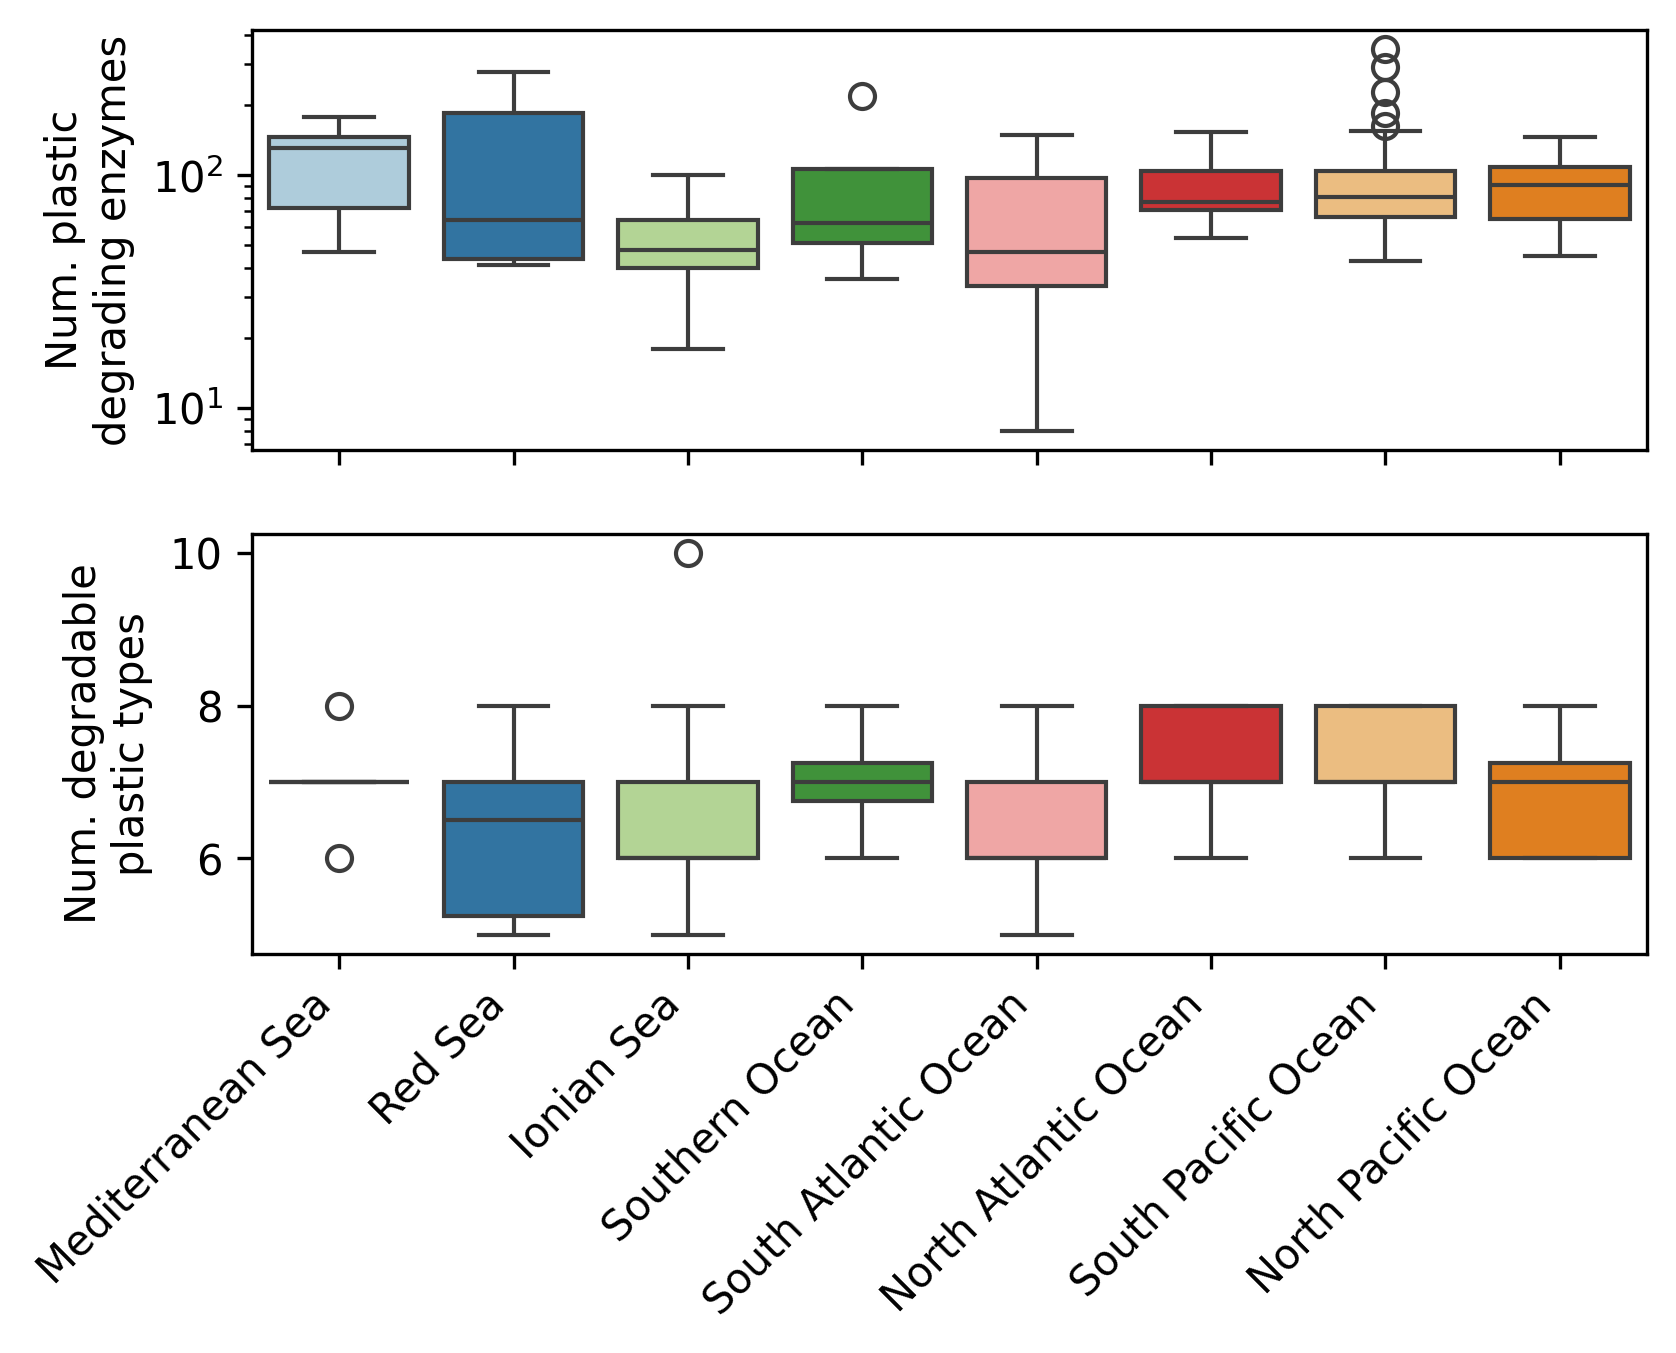

In [ ]:
# per ocean region - separate plots
# average per sampling site and variability
# make long df and use facet grid
dfs1 = dfs.merge(tara_metadata[['ocean','ocean_long']].drop_duplicates(),
                 on='ocean',how='left').drop(columns=['ocean']).rename(columns={'ocean_long':'ocean'})
col2 = 'ocean'

tmp = []
tmp.append(dfs1.groupby([col2,col]).plastic.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. plast.'
tmp.append(dfs1.groupby([col2,col]).hmm_model.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hmms'
tmp.append(dfs1.groupby([col2,col]).target_name.count().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hits'

# via subplots
mpl.rcParams['figure.dpi'] = 300
fig, axs = plt.subplots(2,figsize=(6,4))

pal = sns.color_palette()
dic = dict(zip(ocean_order, pal))
dic

k=0
for what in ['Num. hits','Num. plast.']:#pd.concat(tmp).ylabel.unique():
    sns.boxplot(data=pd.concat(tmp).query('ylabel==@what'),
                x=col2,y='value',
                order=[x[0] for x in df_ocean.set_index('short').loc[ocean_order].values],
                ax=axs[k],
                palette=palett
               )
    if what == 'Num. hits':
        axs[k].set_ylabel(label_hits_n)
    else:
        axs[k].set_ylabel(label_plast_n)
    k+=1

axs[-1].get_shared_x_axes().join(*axs)
[axs[k].set_xticklabels([]) for k in range(1)]
[axs[k].set_xlabel('') for k in range(1)]
plt.xticks(rotation=45,ha='right')
plt.xlabel('')
axs[0].set_yscale('log')
#axs[0].set_title('Ocean')
# NOTE: median value for red sea is in middle as by definition it falls just between the 2 full values
plt.show()

In [ ]:
# all vs the rest significance test
test = stats.ranksums
what = 'Num. hits'
data = pd.concat(tmp).query('ylabel==@what')
data

ranksum = []
for var in data.ocean.unique():
    r,p = test(data.query('ocean==@var').value,
         data.query('ocean!=@var').value
        )
    n = data.query('ocean==@var').shape[0]
    ranksum.append([var,p,n])
pd.DataFrame(ranksum,columns=['ocean','p','n'])

,ocean,p,n
0,Ionian Sea,0.000002,27
1,Mediterranean Sea,0.007674,12
2,North Atlantic Ocean,0.144683,21
3,North Pacific Ocean,0.200435,16
4,Red Sea,1.000000,6
5,South Atlantic Ocean,0.049401,19
6,South Pacific Ocean,0.028682,34
7,Southern Ocean,0.691469,4


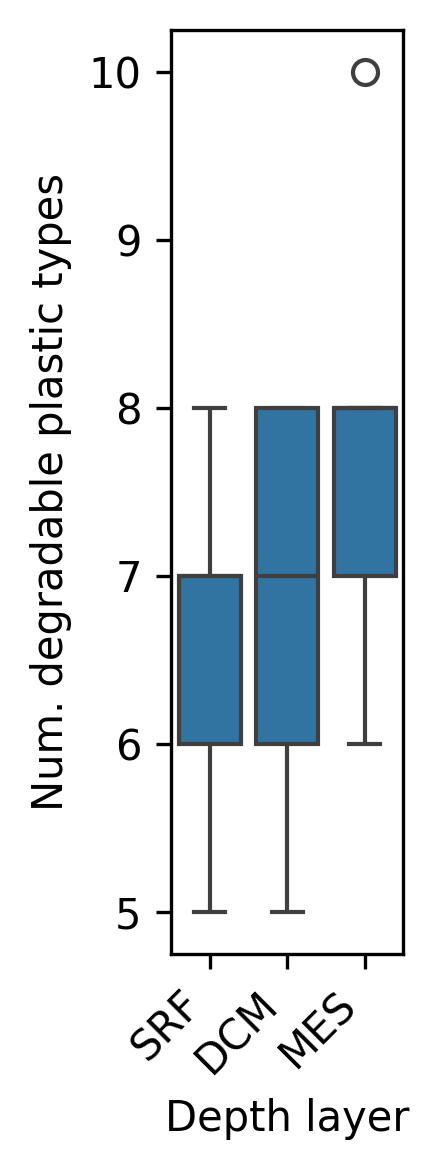

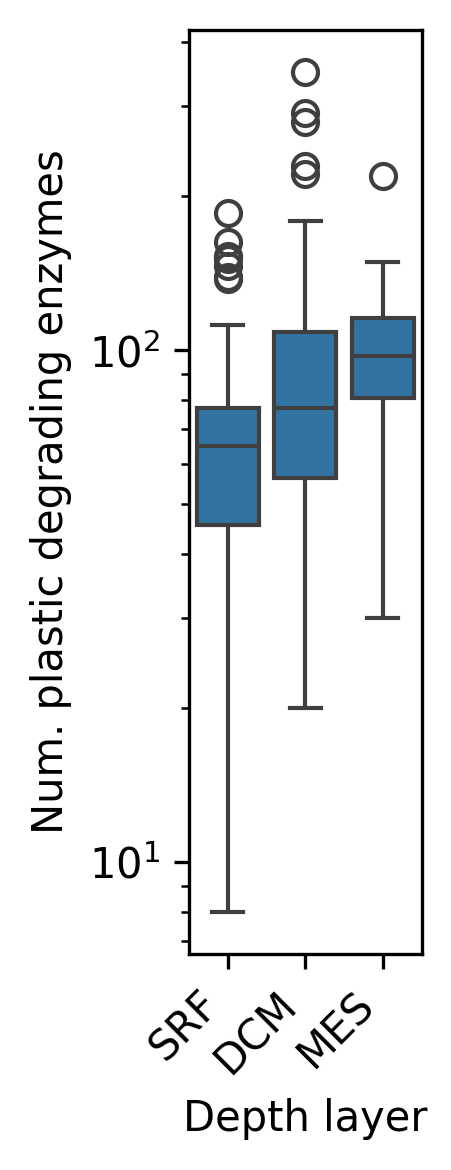

In [ ]:
# per depth layer

tmp = []
tmp.append(dfs1.groupby(col).plastic.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. plast.'
tmp.append(dfs1.groupby(col).hmm_model.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hmms'
tmp.append(dfs1.groupby(col).target_name.count().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hits'

# make separate plots
for coll in ["Num. plast.","Num. hits"]:
    plt.figure(figsize=(1,4))
    ax=sns.boxplot(data=pd.concat(tmp)
            .merge(tara_metadata[[col,'depth_id']],
                     on=col,how='left')
                .query('ylabel==@coll'),
               y='value',x='depth_id',
                   order=['SRF','DCM','MES']
               )
    if coll == 'Num. hits':
        plt.ylabel(label_hits)
        plt.yscale('log')
    else:
        plt.ylabel(label_plast)
    plt.xticks(rotation=45,ha='right')
    plt.xlabel('Depth layer')

    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')

    plt.show()

# Correlation analysis

In [ ]:
df_rich = (dfs
   .groupby(col)
    .target_name.count()
    .rename('num_hits')
    .reset_index()
)
df_rich['pl_richness'] = (dfs
   .groupby(col)
   .plastic.nunique()
   .values
)
df_rich['hmm_richness'] = (dfs
   .groupby(col)
   .hmm_model.nunique()
   .values
)
df_rich.head()

,group_id,num_hits,pl_richness,hmm_richness
0,ERR315856,47,7,20
1,ERR315857,68,7,21
2,ERR315858|ERR315861,62,7,18
3,ERR315859|ERR315860,74,6,18
4,ERR315862|ERR315863,112,7,22


### Environmental variables

In [ ]:
# merge
data = (df_rich
 .merge(df_env,
        on=col,how='left')
)

# correlatons
x = ['num_hits', 'pl_richness']
y = col_env
name_map = []
df_pcc = []
for colx in x:
    for coly in y:
        tmp1 = data[[colx,coly]].dropna()
        tmp2 = corr_f(tmp1[colx],tmp1[coly])
        df_pcc.append([colx,coly,tmp2[0],tmp2[1],tmp1.shape[0]])

df_pcc = (pd
          .DataFrame(df_pcc,columns=['x','y','r','p','n'])
          .query('p<1e-4')
          .sort_values(by='r',ascending=False)
          .replace({"y": dic_env})
         )
df_pcc.query('x.isin(["num_hits","pl_richness"])')

,x,y,r,p,n
14,pl_richness,Depth,0.551792,4.019477e-12,135
20,pl_richness,Nitrate,0.454453,6.910839e-07,109
18,pl_richness,Density,0.394944,2.781039e-06,132
2,num_hits,Depth,0.384048,4.258685e-06,135
6,num_hits,Density,0.381601,6.343546e-06,132
5,num_hits,Temperature,-0.336313,6.661182e-05,135
1,num_hits,Longitude,-0.357203,1.584400e-05,139
13,pl_richness,Longitude,-0.392967,1.708920e-06,139
15,pl_richness,Conductivity,-0.417588,6.305319e-07,132
17,pl_richness,Temperature,-0.450976,4.040710e-08,135


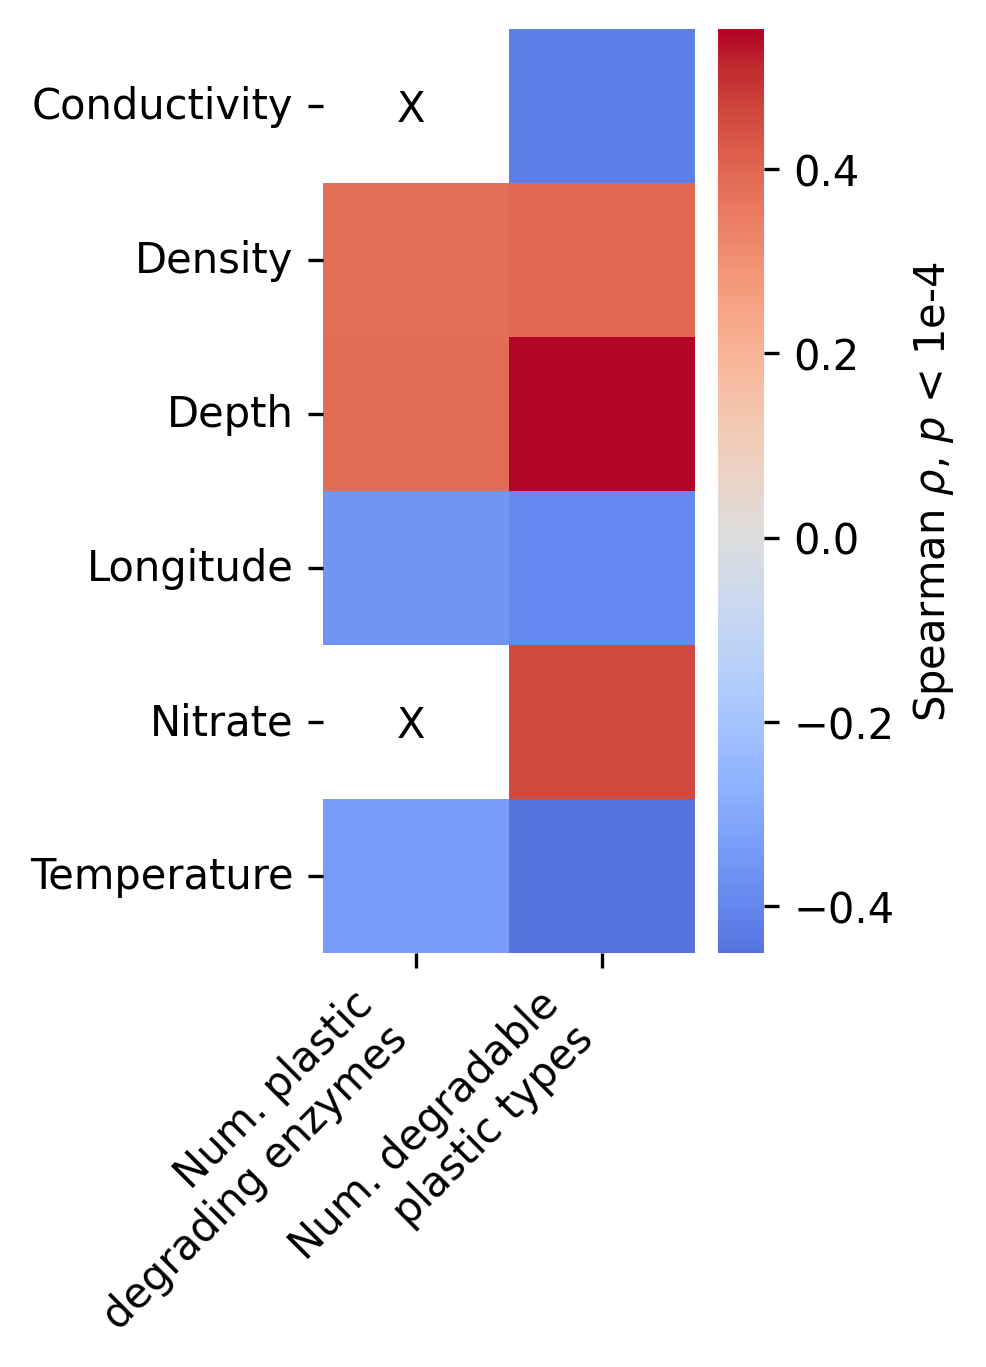

In [ ]:
# plot this heatmap
dic_x = {'num_hits':label_hits_n,
         'pl_richness':label_plast_n
        }

# get data to df
data = (df_pcc
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .pivot(index='x',columns='y',values='r')
        .transpose()
       )
data

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,4))
sns.heatmap(data[[label_hits_n,label_plast_n]], # ordering
            cmap='coolwarm',
            center=0,
            cbar_kws={'label': "Spearman "+r'$\rho$, $p$ < 1e-4',
                    },
           )
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0,ha='right')
#plt.title('$p$ < 1e-4')

# plot xs for variables that are not below p-val cutoff
plt.annotate('X',xy=(0.4,0.6))
plt.annotate('X',xy=(0.4,4.6))

plt.show()


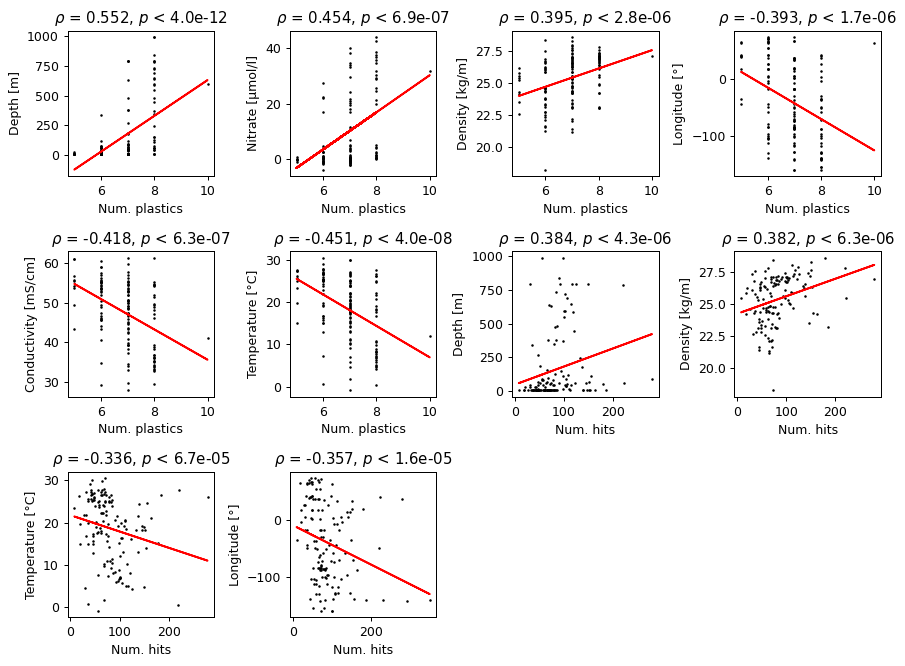

In [ ]:
# Plot all correlations subplot
dic_x = {'num_hits': 'Num. hits',
         'pl_richness': 'Num. plastics'
        }

mpl.rcParams['figure.dpi'] = 90
dic_env_inv = {v: k for k, v in dic_env.items()}
data = (df_rich
 .merge(df_env,
        on=col,how='left')
)
tmp = (df_pcc
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .sort_values(by='x',ascending=False)
)

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(10,7.5))
k=1
for idx,row in tmp.iterrows():

    plt.subplot(3,4,k)
    var1 = df_pcc.loc[idx].x
    var2 = dic_env_inv[df_pcc.loc[idx].y]
    x = data[[var1,var2]].dropna()[var1]
    y = data[[var1,var2]].dropna()[var2]

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
    plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
    plt.plot(x, slope*x+intercept, 'r', label='fitted line')
    plt.xlabel(row.x)
    plt.ylabel(dic_env2[var2])
    plt.title(r'$\rho$ = '+str("%.3f" % corr_f(x,y)[0])+
            ', $p$ < '+str("%.1e" % fix_pvals(corr_f(x,y)[1])))
    k+=1

plt.tight_layout()
plt.show()

### Pollution data

In [ ]:
#https://geopandas.org/mapping.html
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
import geopandas as gpd
from shapely.geometry import Point

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

# fit tara location data to geo-data stucture
geometry = [Point(xy) for xy in zip(tara_metadata['longitude'],
                                     tara_metadata['latitude'])]

geo_df = (gpd
          .GeoDataFrame(tara_metadata[col],
                          geometry=geometry)
         )
# plot
mpl.rcParams['figure.dpi'] = 90
fig,ax = plt.subplots(figsize=(10,10))
world.plot(ax=ax,color='lightgrey', edgecolor='k')
geo_df.plot(ax=ax,marker='o',color='r',markersize=10)
plt.show()

AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

In [ ]:
# load pollution data
import pandas as pd

df_pol = []

# Total Pieces/L, global
df_pol.append(pd
              .read_excel('WW Marine Datashare.xlsx',sheet_name='Q1')
              .rename(columns={'Sample Longitude':'longitude',
                               'Sample Latitude':'latitude',
                               'Total Pieces/L':'conc'
                              })
             )
df_pol[-1]['dataset'] = 'adventure'

# g/km2, global
df_pol.append(pd
              .read_excel('PlasticMarinePollutionGlobalDataset_Eriksen2014.xlsx')
              .drop(0)
              .rename(columns={'Longitude':'longitude',
                               'Latitude':'latitude'})
             )
# merge concentrations across all plastic sizes
#df_pol[-1]['dataset'] = 'eriksen2014'
#print(df_pol)

df_pol[-1]['conc'] = (df_pol[-1]['WD1'].fillna(0)+
                      df_pol[-1]['WD2'].fillna(0)+
                      df_pol[-1]['WD3'].fillna(0)+
                      df_pol[-1]['WD4'].fillna(0))
df_pol[-1]['dataset'] = 'eriksen2014'

# pieces/km2, this is only pacific
df_pol.append(pd.read_csv('Pacific_Law_plastics.txt',
                      delim_whitespace=True,skiprows=1,
                     names=['month','day','year','longitude','latitude','conc']))
df_pol[-1]['dataset'] = 'law2014'

# mg/m³, only north pacific
df_pol.append(pd
              .read_csv('MicroplasticNumericalandMassConcentration_Goldstein2012.csv')
                .rename(columns={'Longitude (º)':'longitude',
                                 'Latitude (º)':'latitude',
                                 'Microplastic Mass (mg/m³)':'conc'})
             )
df_pol[-1]['dataset'] = 'goldstein2012'

# standardize
for d in df_pol:
    a,_ = stats.boxcox([x+1 for x in normalize(d.conc.values)])
    d['conc_box_zscore'] = preprocessing.scale(a)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# fit tara location data to geo-data stucture
geometry = [Point(xy) for xy in zip(tara_metadata['longitude'],
                                     tara_metadata['latitude'])]

geo_df = (gpd
          .GeoDataFrame(tara_metadata[col],
                          geometry=geometry)
         )

In [ ]:
# make geo dfs
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
geo_df_pol = []
for x in df_pol:
    geo_df_pol.append(gpd.GeoDataFrame(x[['conc_box_zscore','dataset']],
                          geometry=[Point(xy) for xy in zip(x['longitude'],
                                        x['latitude'] )])
                     )
print([len(x) for x in geo_df_pol])

geo_df_near = []
for x in geo_df_pol:
  geo_df_near.append(ckdnearest(geo_df, x))



geo_df_near = pd.concat(geo_df_near)
geo_df_near['dist'] = geo_df_near.dist*100 # dist in km

print(geo_df_near.shape)

# prokaryote enriched fraction + surface fraction only
tmp = (tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))
              &(tara_metadata.depth_id=='SRF')][col])

# remove nan datasets
geo_df_near = (geo_df_near
               .dropna(subset=['dataset'])
               .query('group_id.isin(@tmp)')
              )

print(geo_df_near.shape)
geo_df_near.head()

geo_df_near.to_csv("pollutionData.txt", sep='\t')



[1393, 1571, 2529, 235]
(972, 5)
(252, 5)
